## Skin Cancer Classification Transfer Learning VGG16

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn

### Creating Dataset

In [5]:
os.mkdir("HAM_Dataset")
base = "HAM_Dataset"

os.mkdir(os.path.join(base, "MEL"))
os.mkdir(os.path.join(base, "NV"))
os.mkdir(os.path.join(base, "BCC"))
os.mkdir(os.path.join(base, "AKIEC"))
os.mkdir(os.path.join(base, "BKL"))
os.mkdir(os.path.join(base, "DF"))
os.mkdir(os.path.join(base, "VASC"))

In [7]:
for image in os.listdir('HAM_images'):
  if "jpg" not in image:
    os.remove('HAM_images/'+image)

for image in os.listdir('HAM_images'):
  if "jpg" not in image:
    print(image)

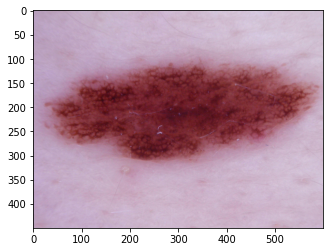

(450, 600, 3)


In [8]:
img = os.listdir('HAM_images')[0]
skin=cv2.imread('HAM_images/'+img)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.show()

print(skin.shape)

In [9]:
print(os.listdir(base))

['AKIEC', 'NV', 'BKL', 'DF', 'VASC', 'MEL', 'BCC']


In [10]:
mapping = {0:"MEL", 1:"NV", 2:"BCC", 3:"AKIEC", 4:"BKL", 5:"DF", 6:"VASC"}

df_labels = pd.read_csv("ISIC2018GroundTruth.csv")
for i in range(len(df_labels)):
    labels = df_labels.iloc[i,1:]
    df_labels.loc[i,"label"] = mapping[list(labels).index(1)]

#df_labels["label"]=df_labels["label"].astype(int)
df_labels.set_index('image', inplace=True)

df_labels.head()

,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label
image,,,,,,,,
ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


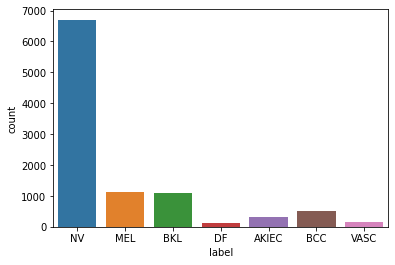

In [11]:
sns.countplot(df_labels["label"])
plt.show()

In [12]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'],
                                                  y=df_labels["label"])

In [13]:
class_wt_dict=dict(enumerate(class_weights))
class_wt_dict

{0: 4.375273044997815,
 1: 2.78349082823791,
 2: 1.301832835044846,
 3: 12.440993788819876,
 4: 1.2854575792581184,
 5: 0.21338020666879728,
 6: 10.075452716297788}

In [16]:
from tqdm import tqdm

images = os.listdir('HAM_images')

for image in tqdm(images):
    
    fname=image[:-4]
    label=df_labels.loc[fname, "label"]
    src = os.path.join('HAM_images', image)
    dst = os.path.join('HAM_Dataset', label, image)
    shutil.copyfile(src, dst)

100%|██████████| 10015/10015 [01:07<00:00, 148.08it/s]


### Train Test Split

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preprocess


image_gen = ImageDataGenerator(preprocessing_function=vgg_preprocess, validation_split=0.15)

In [18]:
data_dir = 'HAM_Dataset'
batch_size = 128
target_size = (224,224)
train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}


##     

## Transfer Learning using VGG16 Model

In [19]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg16_model.layers[:-1]:
    layer.trainable = False

x = vgg16_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=vgg16_model.input, outputs=x)


tl_model.summary()
tl_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

## Model Training

In [21]:
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model.hdf5',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

In [26]:
history = tl_model.fit(train_image_gen,
                    epochs=20, 
                    validation_data = test_image_gen,
                    class_weight=class_wt_dict,
                    callbacks=callback_list)

Epoch 1/20
67/67 [==============================] - 125s 2s/step - loss: 0.3214 - accuracy: 0.7919 - val_loss: 0.7819 - val_accuracy: 0.7658

Epoch 00001: val_accuracy improved from 0.75117 to 0.76584, saving model to best_model.hdf5
Epoch 2/20
67/67 [==============================] - 122s 2s/step - loss: 0.3196 - accuracy: 0.8073 - val_loss: 0.8108 - val_accuracy: 0.7592

Epoch 00002: val_accuracy did not improve from 0.76584
Epoch 3/20
67/67 [==============================] - 118s 2s/step - loss: 0.3069 - accuracy: 0.7932 - val_loss: 0.8110 - val_accuracy: 0.7692

Epoch 00003: val_accuracy improved from 0.76584 to 0.76918, saving model to best_model.hdf5
Epoch 4/20
67/67 [==============================] - 124s 2s/step - loss: 0.3213 - accuracy: 0.7977 - val_loss: 0.7915 - val_accuracy: 0.7665

Epoch 00004: val_accuracy did not improve from 0.76918
Epoch 5/20
67/67 [==============================] - 119s 2s/step - loss: 0.2616 - accuracy: 0.8116 - val_loss: 0.8262 - val_accuracy: 0.76

### Model Evaluation

In [27]:
df=pd.DataFrame(tl_model.history.history)
df.to_csv('hist2.csv')

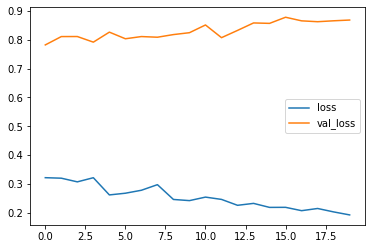

In [28]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

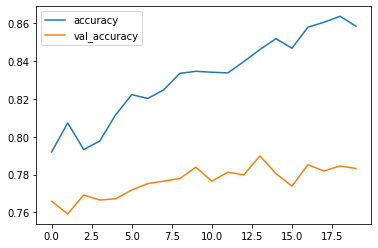

In [29]:
metrics[["accuracy","val_accuracy"]].plot()

In [ ]:
model.evaluate(test_image_gen)

4/4 [==============================] - 23s 6s/step - loss: 1.4655 - accuracy: 0.4215


[1.4654699563980103, 0.42149999737739563]

In [30]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)

test_labels = test_image_gen.classes

12/12 [==============================] - 15s 1s/step


In [31]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(test_labels, predictions)

In [32]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.44897959 0.20408163 0.20408163 0.         0.04081633 0.10204082
  0.        ]
 [0.1038961  0.64935065 0.07792208 0.03896104 0.03896104 0.07792208
  0.01298701]
 [0.02439024 0.03658537 0.59146341 0.01829268 0.13414634 0.19512195
  0.        ]
 [0.11764706 0.05882353 0.11764706 0.35294118 0.         0.35294118
  0.        ]
 [0.03614458 0.03614458 0.13253012 0.         0.51204819 0.28313253
  0.        ]
 [0.0039801  0.01691542 0.02985075 0.0039801  0.04676617 0.89651741
  0.00199005]
 [0.         0.04761905 0.         0.         0.         0.33333333
  0.61904762]]


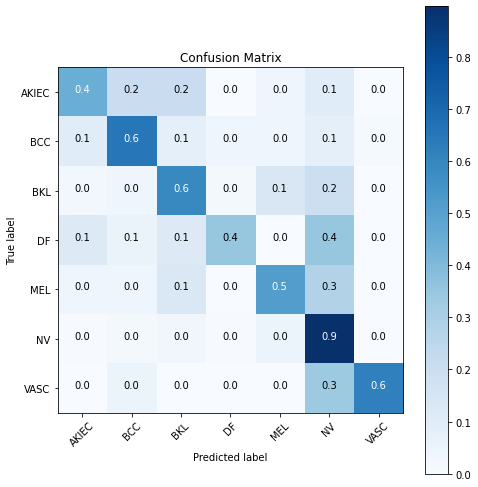

In [33]:
cm_plot_labels = list(test_image_gen.class_indices.keys())

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [34]:
print(classification_report(test_image_gen.classes, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.48      0.45      0.46        49
           1       0.55      0.65      0.60        77
           2       0.58      0.59      0.59       164
           3       0.38      0.35      0.36        17
           4       0.53      0.51      0.52       166
           5       0.90      0.90      0.90      1005
           6       0.81      0.62      0.70        21

    accuracy                           0.78      1499
   macro avg       0.60      0.58      0.59      1499
weighted avg       0.78      0.78      0.78      1499

